<img src="../images/logos/xradar_logo.svg" width=250 alt="xradar"></img>

# Xradar Basics


---

## Overview

1. Xradar general overview
1. Radar data IO
2. Radar data georeferencing
3. Data visualization
   

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray) | Necessary |  Basic features |
| [Radar Cookbook](https://projectpythia.org/radar-cookbook/) | Necessary |  Radar basics |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib) | Necessary |  Plotting basic features |
- **Time to learn**: 30 minutes
---

## Imports

In [1]:
import xradar as xd
import pyart
import wradlib as wrl

import fsspec
import numpy as np
from xarray.backends.api import open_datatree

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Xradar

`Xradar` is a `Python` package developed to streamline the **reading** and **writing** of radar data across various formats, with exports aligned to standards like ODIM_H5 and CfRadial. Born from the **Open Radar Science Community's** collaboration at **ERAD2022**, `Xradar` uses an `xarray-based` data model, compatible with the upcoming **CfRadial2.1/FM301** standard. This ensures seamless integration with other xarray-based software and existing open-source radar processing tools.

### Xradar data model
Xradar leverages the upcoming FM301 standard, a subset of CfRadial2.0, using Xarray to efficiently manage radar data.

#### DataTree Structure (CfRadial2.1/FM301 standard)
Xradar employs `xarray.DataTree` objects to organize radar sweeps within a single structure, where each sweep is an `xarray.Dataset` containing relevant metadata and variables.

<img src="../images/CfRadial2.1.svg" width=500 alt="xradar"></img>

## Xradar importers

Xradar supports several importers to handle different radar data formats. These importers typically include:

- **ODIM_H5**: For reading radar data in the ODIM_H5 format, which is widely used in Europe and supported by the EUMETNET OPERA program.

- **CfRadial**: For importing data in the CfRadial format, which is commonly used in the atmospheric sciences community.

- **SIGMET/IRIS**: For ingesting radar data from SIGMET/IRIS formats, which are used by various weather radar systems globally.

- **GAMIC**: For reading data from GAMIC radars, which use their proprietary format.

For more importers check [here](https://docs.openradarscience.org/projects/xradar/en/stable/importers.html)

Let's find some Canadian radar data located at the ams 2025 Bucket

In [2]:
# Set the URL and path for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = f"pythia/radar/ams2025"

fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

fs.glob(f"{path}/*")

['pythia/radar/ams2025/CalgaryHailStorm2024',
 'pythia/radar/ams2025/OntarioDerecho2022']

In [3]:
files = fs.glob(
    "pythia/radar/ams2025/CalgaryHailStorm2024/*.h5"
)
files[:3]

['pythia/radar/ams2025/CalgaryHailStorm2024/2024080600_00_ODIMH5_PVOL6S_VOL_CASSM.h5',
 'pythia/radar/ams2025/CalgaryHailStorm2024/2024080600_06_ODIMH5_PVOL6S_VOL_CASSM.h5',
 'pythia/radar/ams2025/CalgaryHailStorm2024/2024080600_12_ODIMH5_PVOL6S_VOL_CASSM.h5']

In [4]:
radar_files = [f"s3://{i}" for i in files]
radar_files[-3:]

['s3://pythia/radar/ams2025/CalgaryHailStorm2024/2024080605_42_ODIMH5_PVOL6S_VOL_CASSM.h5',
 's3://pythia/radar/ams2025/CalgaryHailStorm2024/2024080605_48_ODIMH5_PVOL6S_VOL_CASSM.h5',
 's3://pythia/radar/ams2025/CalgaryHailStorm2024/2024080605_54_ODIMH5_PVOL6S_VOL_CASSM.h5']

In [5]:
local_files = [
    fsspec.open_local(
        f"simplecache::{URL}{i}", s3={"anon": True}, filecache={"cache_storage": "."}
    )
    for i in files
]

We can open one of this `nc` files using `xradar.io.open_cfradial1_datree` method

In [6]:
# with fs.open(radar_files[0], mode="rb", anon=True, client_kwargs=dict(endpoint_url=URL)) as file:
#     dtree = xd.io.open_cfradial1_datatree(file)

In [7]:
dt = xd.io.open_odim_datatree(local_files[-1])
display(dt)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2024-08-06T05:48:03Z'
│       time_coverage_end    <U20 80B '2024-08-06T05:53:37Z'
│       longitude            float64 8B -113.4
│       altitude             float64 8B 991.3
│       latitude             float64 8B 51.21
│   Attributes:
│       Conventions:      ODIM_H5/V2_4
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:04.20832...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float64 3kB 0.497 1.502 2.504 ... 358.5 359.5
│       Data variables: (12/15)
│           DBZH               (azimuth, range) float64 706kB ...
│           TH                 (azimuth, range) float64 706kB ...
│           RHOHV              (azimuth, range) float64 706kB ...
│           UPHIDP             (azimuth, range) float64 706kB ...
│           WRADH              (azimuth, range) float64 706kB ...
│           PHIDP              (azimuth, range) float64 706kB ...
│           ...                 ...
│           VRADH              (azimuth, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:24.37496...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float64 3kB 0.5025 1.516 2.515 ... 358.5 359.5
│       Data variables: (12/15)
│           DBZH               (azimuth, range) float64 706kB ...
│           TH                 (azimuth, range) float64 706kB ...
│           RHOHV              (azimuth, range) float64 706kB ...
│           UPHIDP             (azimuth, range) float64 706kB ...
│           WRADH              (azimuth, range) float64 706kB ...
│           PHIDP              (azimuth, range) float64 706kB ...
│           ...                 ...
│           VRADH              (azimuth, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:35.35692...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float64 3kB 0.511 1.508 2.502 ... 358.5 359.5
│       Data vari

In this `Xarray.Datatree` object, the first two nodes contains radar metadata and the others contains `Xarray.Datasets` for each sweeps. 

In [8]:
for sweep in dt.children:
    try:
        print(
            f"{sweep} - elevation {np.round(dt[sweep]['sweep_fixed_angle'].values[...], 1)}"
        )
    except KeyError:
        print(sweep)

sweep_0 - elevation 24.4
sweep_1 - elevation 20.2
sweep_2 - elevation 16.6
sweep_3 - elevation 13.7
sweep_4 - elevation 11.3
sweep_5 - elevation 9.4
sweep_6 - elevation 7.7
sweep_7 - elevation 6.4
sweep_8 - elevation 5.3
sweep_9 - elevation 4.4
sweep_10 - elevation 3.5
sweep_11 - elevation 2.7
sweep_12 - elevation 2.1
sweep_13 - elevation 1.6
sweep_14 - elevation 1.2
sweep_15 - elevation 0.8
sweep_16 - elevation 0.4


Let's explore the `1.0` degrees elevation ('sweep_2')

In [9]:
ds_sw2 = dt["sweep_2"].ds
display(ds_sw2)

<xarray.DatasetView> Size: 7MB
Dimensions:            (azimuth: 360, range: 245)
Coordinates:
    elevation          (azimuth) float64 3kB ...
    time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:35.35692...
  * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
    longitude          float64 8B ...
    latitude           float64 8B ...
    altitude           float64 8B ...
  * azimuth            (azimuth) float64 3kB 0.511 1.508 2.502 ... 358.5 359.5
Data variables: (12/15)
    DBZH               (azimuth, range) float64 706kB ...
    TH                 (azimuth, range) float64 706kB ...
    RHOHV              (azimuth, range) float64 706kB ...
    UPHIDP             (azimuth, range) float64 706kB ...
    WRADH              (azimuth, range) float64 706kB ...
    PHIDP              (azimuth, range) float64 706kB ...
    ...                 ...
    VRADH              (azimuth, range) float64 706kB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B 16.6

## Xradar visualization

We can make a plot using [`xarray.plot`](https://docs.xarray.dev/en/latest/user-guide/plotting.html) functionality.

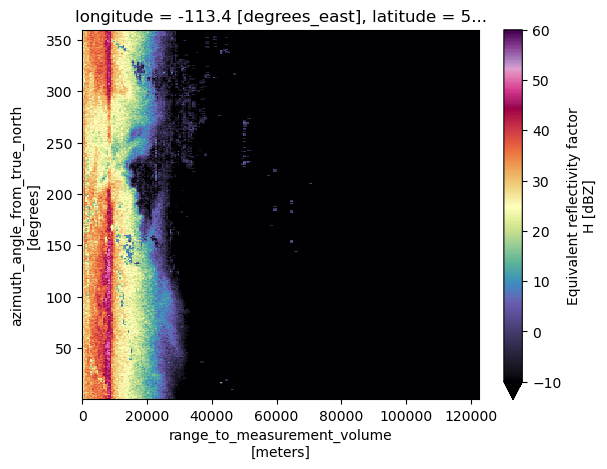

In [10]:
ds_sw2.DBZH.plot(
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

The radar data in the `Xarray.Dataset` object includes range and azimuth as coordinates. To create a radial plot, apply the [`xradar.georeference`](https://docs.openradarscience.org/projects/xradar/en/stable/georeference.html) method. This method will generate x, y, and z coordinates for the plot.

In [11]:
ds_sw2 = ds_sw2.xradar.georeference()
display(ds_sw2)

<xarray.Dataset> Size: 9MB
Dimensions:            (azimuth: 360, range: 245)
Coordinates:
    elevation          (azimuth) float64 3kB 16.63 16.61 16.6 ... 16.59 16.59
    time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:35.35692...
  * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
    longitude          float64 8B -113.4
    latitude           float64 8B 51.21
    altitude           float64 8B 991.3
  * azimuth            (azimuth) float64 3kB 0.511 1.508 2.502 ... 358.5 359.5
    crs_wkt            int64 8B 0
    x                  (azimuth, range) float64 706kB 2.136 6.408 ... -1.028e+03
    y                  (azimuth, range) float64 706kB 239.5 718.5 ... 1.167e+05
    z                  (azimuth, range) float64 706kB 1.063e+03 ... 3.671e+04
Data variables: (12/15)
    DBZH               (azimuth, range) float64 706kB ...
    TH                 (azimuth, range) float64 706kB ...
    RHOHV              (azimuth, range) float64 706kB ...
    UPHIDP             (azimuth, range) float64 706kB ...
    WRADH              (azimuth, range) float64 706kB ...
    PHIDP              (azimuth, range) float64 706kB ...
    ...                 ...
    VRADH              (azimuth, range) float64 706kB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B 16.6

We can now create a radial plot passing `x` and `y` coordinates

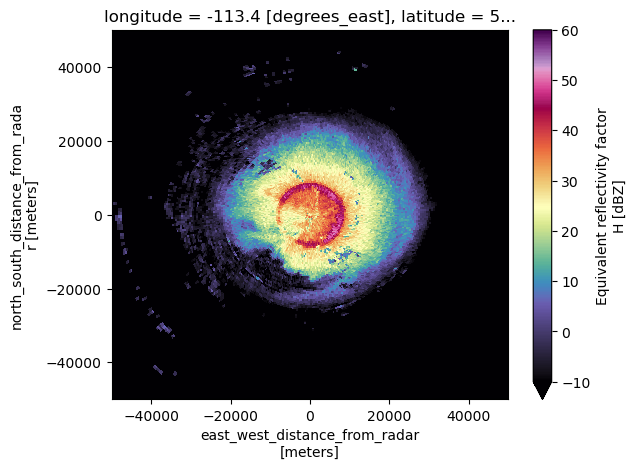

In [12]:
ds_sw2.DBZH.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
    xlim=(-50_000, 50_000),
    ylim=(-50_000, 50_000)
)

## Data slicing

We can use the power of `Xarray` to acces data within the first 50 kilometers by [slicing](https://foundations.projectpythia.org/core/xarray/xarray-intro/#slicing-along-coordinates) along coordinates.

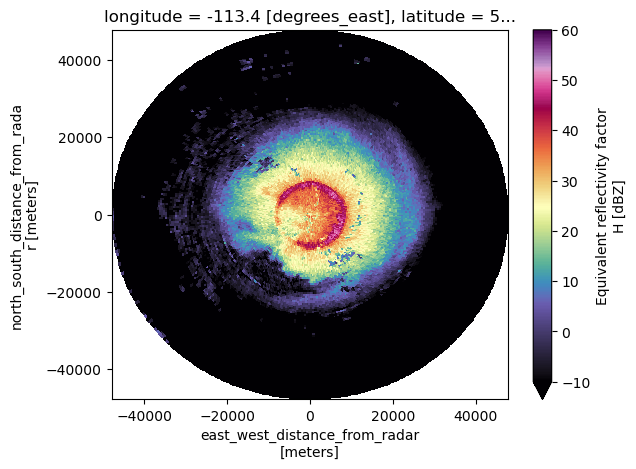

In [13]:
ds_sw2.sel(range=slice(0, 5e4)).DBZH.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

Let's suposse we want to subset between 90 and 180 degrees angle in azumith

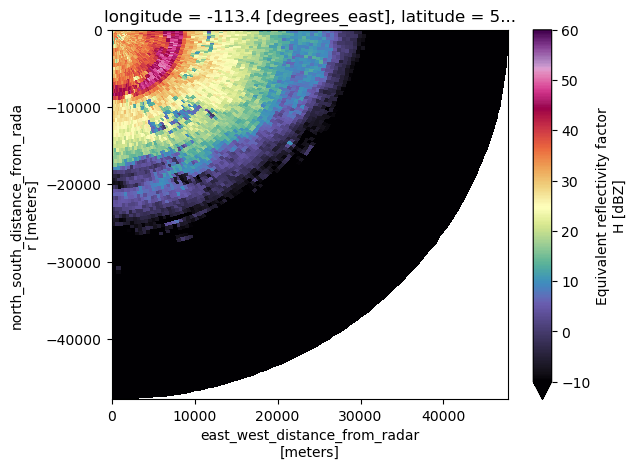

In [14]:
ds_sw2.sel(azimuth=slice(90, 180), range=slice(0, 5e4)).DBZH.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

Perhaps, we just what to see radar reflectivity along the 100 degrees angle in azimuth

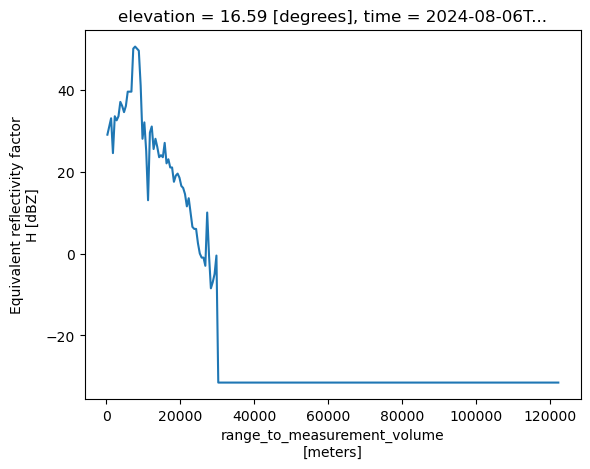

In [15]:
ds_sw2.sel(azimuth=125, method="nearest").DBZH.plot()

## Xradar integration

### Py-Art

`Xradar` datatree objects can be ported to `Py-ART` radar objects using the pyart.xradar.Xradar method.

In [16]:
dt

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2024-08-06T05:48:03Z'
│       time_coverage_end    <U20 80B '2024-08-06T05:53:37Z'
│       longitude            float64 8B -113.4
│       altitude             float64 8B 991.3
│       latitude             float64 8B 51.21
│   Attributes:
│       Conventions:      ODIM_H5/V2_4
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:04.20832...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float64 3kB 0.497 1.502 2.504 ... 358.5 359.5
│       Data variables: (12/15)
│           DBZH               (azimuth, range) float64 706kB ...
│           TH                 (azimuth, range) float64 706kB ...
│           RHOHV              (azimuth, range) float64 706kB ...
│           UPHIDP             (azimuth, range) float64 706kB ...
│           WRADH              (azimuth, range) float64 706kB ...
│           PHIDP              (azimuth, range) float64 706kB ...
│           ...                 ...
│           VRADH              (azimuth, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B 24.4
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:24.37496...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float64 3kB 0.5025 1.516 2.515 ... 358.5 359.5
│       Data variables: (12/15)
│           DBZH               (azimuth, range) float64 706kB ...
│           TH                 (azimuth, range) float64 706kB ...
│           RHOHV              (azimuth, range) float64 706kB ...
│           UPHIDP             (azimuth, range) float64 706kB ...
│           WRADH              (azimuth, range) float64 706kB ...
│           PHIDP              (azimuth, range) float64 706kB ...
│           ...                 ...
│           VRADH              (azimuth, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B 20.2
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:35.35692...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B -113.4
│           latitude           float64 8B 51.21
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float64 3kB 0.511 1.508 2.502 ... 358.5 359.5
│       Da

In [17]:
dt = xd.io.open_odim_datatree(local_files[-1])
radar = dt.pyart.to_radar()

In [18]:
radar.combined_sweeps

<xarray.Dataset> Size: 438MB
Dimensions:            (gates: 8280, range: 660, sweep_number: 17)
Coordinates:
  * range              (range) float32 3kB 250.0 750.0 ... 3.292e+05 3.298e+05
    elevation          (gates) float64 66kB 24.38 24.4 24.42 ... 0.396 0.396
    time               (gates) datetime64[ns] 66kB 2024-08-06T05:48:04.208328...
    longitude          float64 8B -113.4
    latitude           float64 8B 51.21
    altitude           float64 8B 991.3
  * gates              (gates) object 66kB MultiIndex
  * sweep_number       (gates) int64 66kB 0 0 0 0 0 0 0 ... 16 16 16 16 16 16 16
  * azimuth            (gates) float64 66kB 0.497 1.502 2.504 ... 359.2 359.7
Data variables: (12/15)
    DBZH               (gates, range) float64 44MB 28.5 33.5 ... -31.5 -31.5
    TH                 (gates, range) float64 44MB 47.5 33.5 ... -31.5 -31.5
    RHOHV              (gates, range) float64 44MB 0.7362 0.9961 ... 0.0 0.0
    UPHIDP             (gates, range) float64 44MB 29.9 28.88 30.05 ... 0.0 0.0
    WRADH              (gates, range) float64 44MB 4.389 1.881 ... 0.06271
    PHIDP              (gates, range) float64 44MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                 ...
    VRADH              (gates, range) float64 44MB -6.824 -5.813 ... -48.2 -48.2
    sweep_mode         (gates) object 66kB 'azimuth_surveillance' ... 'azimut...
    prt_mode           (gates) object 66kB 'not_set' 'not_set' ... 'not_set'
    follow_mode        (gates) object 66kB 'not_set' 'not_set' ... 'not_set'
    sweep_fixed_angle  (sweep_number) float64 136B 0.4 0.8 1.2 ... 20.2 24.4
    ngates             (gates) int64 66kB 0 1 2 3 4 ... 8275 8276 8277 8278 8279

In [19]:
radar.combined_sweeps.sel(sweep_number=2)

<xarray.Dataset> Size: 19MB
Dimensions:            (azimuth: 360, range: 660, sweep_number: 17)
Coordinates:
  * range              (range) float32 3kB 250.0 750.0 ... 3.292e+05 3.298e+05
    elevation          (azimuth) float64 3kB 16.63 16.61 16.6 ... 16.59 16.59
    time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:35.35692...
    longitude          float64 8B -113.4
    latitude           float64 8B 51.21
    altitude           float64 8B 991.3
  * azimuth            (azimuth) float64 3kB 0.511 1.508 2.502 ... 358.5 359.5
    sweep_number       int64 8B 2
Data variables: (12/15)
    DBZH               (azimuth, range) float64 2MB 28.0 30.5 30.5 ... nan nan
    TH                 (azimuth, range) float64 2MB 47.0 30.5 30.5 ... nan nan
    RHOHV              (azimuth, range) float64 2MB 0.7835 0.9843 ... nan nan
    UPHIDP             (azimuth, range) float64 2MB 34.06 31.76 ... nan nan
    WRADH              (azimuth, range) float64 2MB 2.884 2.383 ... nan nan
    PHIDP              (azimuth, range) float64 2MB 0.0 0.0 0.0 ... nan nan nan
    ...                 ...
    VRADH              (azimuth, range) float64 2MB -6.572 -5.308 ... nan nan
    sweep_mode         (azimuth) object 3kB 'azimuth_surveillance' ... 'azimu...
    prt_mode           (azimuth) object 3kB 'not_set' 'not_set' ... 'not_set'
    follow_mode        (azimuth) object 3kB 'not_set' 'not_set' ... 'not_set'
    sweep_fixed_angle  (sweep_number) float64 136B 0.4 0.8 1.2 ... 20.2 24.4
    ngates             (azimuth) int64 3kB 720 721 722 723 ... 1077 1078 1079

In [20]:
def generate_title(radar, field, sweep, datetime_format=None, use_sweep_time=True):
    """
    Generate a title for a plot.

    Parameters
    ----------
    radar : Radar
        Radar structure.
    field : str
        Field plotted.
    sweep : int
        Sweep plotted.
    datetime_format : str
        Format of datetime (using strftime format).
    use_sweep_time : bool
        If true, the current sweep's beginning time is used.

    Returns
    -------
    title : str
        Plot title.

    """
    if use_sweep_time:
        begin_time = pyart.graph.generate_radar_time_sweep(radar, sweep)
    else:
        begin_time = pyart.graph.generate_radar_time_begin(radar)
    if datetime_format:
        time_str = begin_time.strftime(datetime_format)
    else:
        time_str = begin_time.isoformat() + "Z"
    fixed_angle = radar.fixed_angle["data"][sweep]
    l1 = f"{pyart.graph.generate_radar_name(radar)} {fixed_angle:.1f} Deg. {time_str} "
    field_name = generate_field_name(radar, field)
    return l1 + "\n" + field_name

In [21]:
radar["sweep_0"].ds.xradar.georeference()

<xarray.Dataset> Size: 9MB
Dimensions:            (azimuth: 360, range: 245)
Coordinates:
    elevation          (azimuth) float64 3kB 24.38 24.4 24.42 ... 24.4 24.4 24.4
    time               (azimuth) datetime64[ns] 3kB 2024-08-06T05:48:04.20832...
  * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
    longitude          float64 8B -113.4
    latitude           float64 8B 51.21
    altitude           float64 8B 991.3
  * azimuth            (azimuth) float64 3kB 0.497 1.502 2.504 ... 358.5 359.5
    crs_wkt            int64 8B 0
    x                  (azimuth, range) float64 706kB 1.975 5.924 ... -991.7
    y                  (azimuth, range) float64 706kB 227.7 683.0 ... 1.107e+05
    z                  (azimuth, range) float64 706kB 1.095e+03 ... 5.221e+04
Data variables: (12/15)
    DBZH               (azimuth, range) float64 706kB ...
    TH                 (azimuth, range) float64 706kB ...
    RHOHV              (azimuth, range) float64 706kB ...
    UPHIDP             (azimuth, range) float64 706kB ...
    WRADH              (azimuth, range) float64 706kB ...
    PHIDP              (azimuth, range) float64 706kB ...
    ...                 ...
    VRADH              (azimuth, range) float64 706kB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...

(-50.0, 50.0)

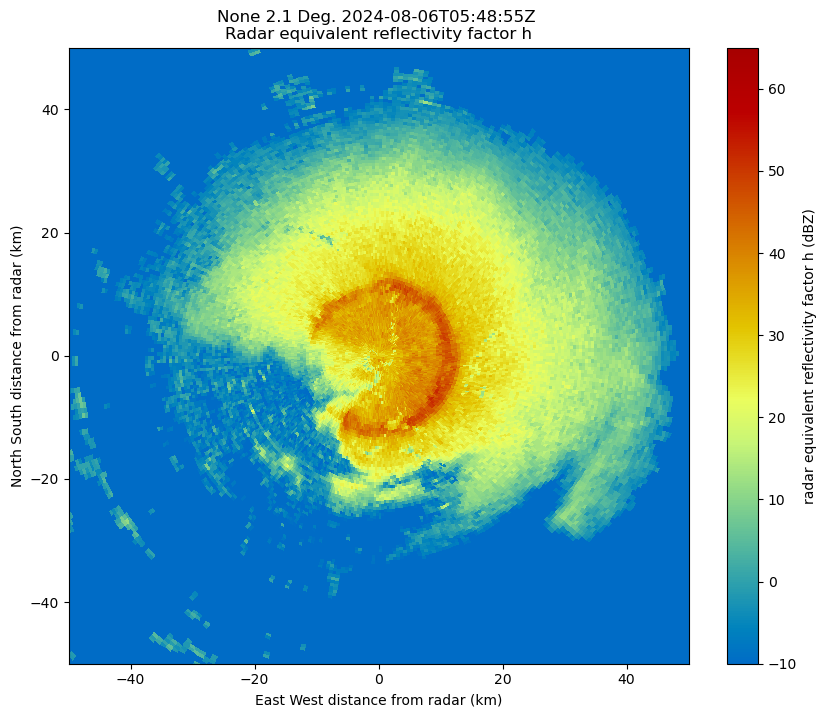

In [22]:
fig = plt.figure(figsize=[10, 8])
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi("DBZH", sweep=4)
plt.ylim(-50, 50)
plt.xlim(-50, 50)

In [23]:
del display

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Challenge Problem!</p>
    Go to the <a href="https://arm-doe.github.io/pyart/examples/index.html">Py-ART Example Gallery</a>, and reproduce one of the examples using the data provided in this tutorial.
</div>

In [31]:
# Insert your solution here

---

### Wradlib

`Wradlib` functionality can also be applied to `Xarray.Datatree` objects. For example, the [`wradlib.georef`](https://docs.wradlib.org/en/latest/georef.html) module can be used to enrich data by adding geographical coordinates.

In [24]:
for key in list(dt.children):
    if "sweep" in key:
        dt[key].ds = dt[key].ds.wrl.georef.georeference(
            crs=wrl.georef.get_default_projection()
        )

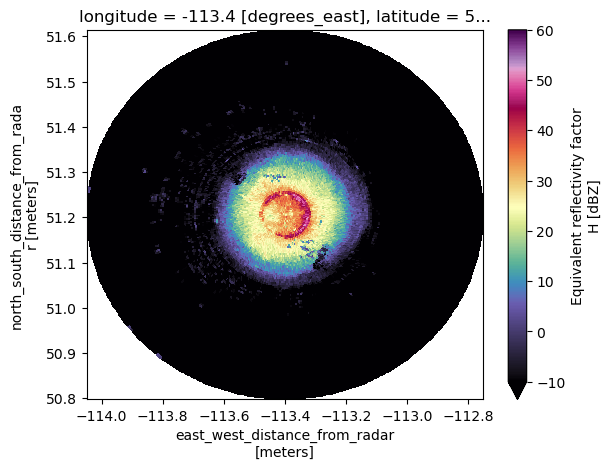

In [25]:
dt["sweep_0"].ds.DBZH.sel(range=slice(0, 5e4)).plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Challenge Problem!</p>
    Go to the <a href="https://docs.wradlib.org/en/latest/notebooks/overview.html">wradlib example gallery</a>, and reproduce one of the examples using the data provided in this tutorial.
</div>

## Xradar exporters

In xradar, exporters convert radar data into various formats for analysis or integration. Exporting is supported for recognized standards, including:

- CfRadial1
- CfRadial2
- ODIM
- Zarr

As an example, we can output our data to `cfradial2` format!

In [26]:
xd.io.to_cfradial2(dt, "radar-data.nc")

In [27]:
dt_back = open_datatree("radar-data.nc", engine="netcdf4")

In [28]:
display(dt_back)

<xarray.DataTree>
Group: /
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 8B ...
│       platform_type        <U5 20B ...
│       instrument_type      <U5 20B ...
│       time_coverage_start  <U20 80B ...
│       time_coverage_end    <U20 80B ...
│       longitude            float64 8B ...
│       altitude             float64 8B ...
│       latitude             float64 8B ...
│   Attributes:
│       Conventions:      Cf/Radial
│       instrument_name:  None
│       version:          2.0
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None: xradar v0.7.0 CfRadial2 export
│       comment:          im/exported using xradar
├── Group: /sweep_0
│       Dimensions:            (time: 360, range: 245)
│       Coordinates:
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2024-08-06T05:48:03.01388876...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           azimuth            (time) float64 3kB ...
│       Data variables: (12/15)
│           DBZH               (time, range) float64 706kB ...
│           TH                 (time, range) float64 706kB ...
│           RHOHV              (time, range) float64 706kB ...
│           UPHIDP             (time, range) float64 706kB ...
│           WRADH              (time, range) float64 706kB ...
│           PHIDP              (time, range) float64 706kB ...
│           ...                 ...
│           VRADH              (time, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_1
│       Dimensions:            (time: 360, range: 245)
│       Coordinates:
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2024-08-06T05:48:15.01388876...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           azimuth            (time) float64 3kB ...
│       Data variables: (12/15)
│           DBZH               (time, range) float64 706kB ...
│           TH                 (time, range) float64 706kB ...
│           RHOHV              (time, range) float64 706kB ...
│           UPHIDP             (time, range) float64 706kB ...
│           WRADH              (time, range) float64 706kB ...
│           PHIDP              (time, range) float64 706kB ...
│           ...                 ...
│           VRADH              (time, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_2
│       Dimensions:            (time: 360, range: 245)
│       Coordinates:
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2024-08-06T05:48:27.01527782...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           azimuth            (time) float64 3kB ...
│       Data variables: (12/15)
│           DBZH               (time, range) float64 706kB ...
│           TH                 (time, range) float64 706kB ...
│           RHOHV              (time, range) float64 706kB ...
│           UPHIDP             (time, range) float64 706kB ...
│           WRADH              (time, range) float64 706kB ...
│           PHIDP              (time, range) float64 706kB ...
│           ...                 ...
│           VRADH              (time, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <

---

## Summary

`Xradar` is a Python library designed for working with radar data. It extends xarray to include radar-specific functionality, such as purpose-based accessors and georeferencing methods. It supports exporting data in various formats, including CfRadial1, CfRadial2, ODIM, and Zarr. xradar facilitates the analysis, visualization, and integration of radar data with other tools and systems.

## Resources and references
 - [Xradar](https://docs.openradarscience.org/projects/xradar/en/stable/index.html)
 - [Radar cookbook](https://github.com/ProjectPythia/radar-cookbook)
 - [Py-Art landing page](https://arm-doe.github.io/pyart/)
 - [Wradlib landing page](https://docs.wradlib.org/en/latest/index.html)
